# This second part is used for processing Idaho data
## including rm nan; calculting wind angle; detrending; rotation

In [1]:
# Turn off annoying warnings
import warnings
warnings.filterwarnings('ignore')
# Make sure the environment is good
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
import math
from scipy import signal
from scipy.stats import skew, kurtosis
from datetime import date, timedelta
import pandas as pd

IN_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data/"
OUT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/basic_processed_data/"
in_var=['u_ins','v_ins','w_ins','q_ins','C_ins','P_ins','Tsonic_ins']
# flg_var=['diag_csat_ins','sig_irga_ins']
flg_var=['diag_csat_ins']
# out_var=['H','E','LE','u_star','T_star','L','L_H2','L_q2','TKE','rot_ang_v']
# out_var=['u_star','T_star','L','L_H2','L_q2']
out_var=['uw']

In [2]:
# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
k   = 0.4      # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2

# EC settings
sonum    =12                       # number of sonic
z        =[1.2,2,3.5,6,8.2,12.8,15.8,23,30.3,40.2,50.6,60.5]                 # height of sonic above ground, m
frequency=10                   # sampling frequency, Hz
time_avg =3600                  # average time, s
rpat = frequency*time_avg
list_col = ['C1','C2','C3','C4','B1','B2','B3','B4','A1','A2','A3','A4']

# set up controls
do_detrend       = 1                # do detrend
do_yawrotation   = 1                # do yaw rotation
do_pitchrotation = 1                # do pitch rotation
webb_corr        = 2                # do webb-corr
plot_spectrum    = 0
tur_saving = 1  
avg_saving = 1

# Creating class for all the processes

In [3]:
def mean_rep(input_var,rep):
    """ function used for calculte the mean of 3d input and expand result to the size of input variable"""
    var_avg = np.repeat(np.nanmean(input_var,axis=1),rep,0)   
    return var_avg
def change_sign(inpt_flx,inpt_tur):
    out_tur = inpt_tur
    flx_rep = np.repeat(inpt_flx,rpat,0)
#     flx_rep = flx_rep.reshape(-1,rpat,sonum)
#     mask_q = flx_rep > 0
    out_tur[flx_rep > 0] = -inpt_tur[flx_rep > 0]
    return out_tur
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day
class basic_process:
    def __init__(self,name,ins):        
        self.name = name  
#         self.DateTime = date_num_ins
        self.ins = ins
        self.ins3d = self.ins.reshape(-1,rpat,sonum)
        self.avg = mean_rep(self.ins3d,rpat)
        self.avg3d = self.avg.reshape(-1,rpat,sonum)
        if(self.ins.shape != self.avg.shape):
            # print('Dimension error')
            raise ValueError('Dimension error')   
    def rmnan(self):  
        """ method used for checking & rm nan"""  
        self.ins[diag_csat_ins >= 65] = np.nan ## ！！！！！ get rid of bad data (thershold is 65)! ! ! ! !
        self.ins3d = self.ins.reshape(-1,rpat,sonum)
        for icol in range(sonum):
            nansum = np.sum(np.isnan(self.ins3d[:,:,icol]),1)
            # if there are more than 10% nan in an hour, discard all data at that level
            for i in range(24):
                if nansum[i] >= time_avg*frequency/10:
                    self.ins3d[i,:,icol] = np.nan
                    self.avg3d[i,:,icol] = np.nan
        self.ins = self.ins3d.reshape(-1,sonum)
        self.avg = self.avg3d.reshape(-1,sonum)
        print('finish:rm nan of '+self.name)
    def dtrd(self):
        """ method used for calculating detrending coefficients"""
        # Note that detrend should not affect the averages  
        # The result is equal to (signal.detrend(self.ins3d) + self.avg3d)
        self.detrend3d = np.zeros((24,rpat,sonum))
        self.detrend3d[:] = np.nan
#         ct = np.zeros((rpat,sonum))
#         for i in range(rpat):
#             ct[i,:] = i+1
#         ct3d = np.broadcast_to(ct,(24,)+ct.shape)
        ns = self.ins3d.shape[1]
        a = -(ns*np.nansum(ct3d * self.ins3d, axis=1) - np.nansum(ct3d, axis=1) *
              np.nansum(self.ins3d, axis=1)) / (ns*np.nansum(ct3d**2, axis=1) - (np.nansum(ct3d, axis=1))**2)
        b = (np.nansum(self.ins3d, axis=1) - a * np.nansum(ct3d, axis=1))/ns
        for i in range(24):
            self.detrend3d[i,:,:] = self.ins3d[i,:,:] + (a[i,:] * ct3d[i,:,:] + b[i,:]) - self.avg3d[i,:,:]
        self.detrend = self.detrend3d.reshape(-1,sonum)
#         print('Finish detrending:'+self.name)   
    def update_ins(self,ins3d):
        """ method used for updating self.ins"""
        self.ins3d = ins3d
        self.ins = self.ins3d.reshape(-1,sonum)
    def update_avg(self,ins3d):
        self.avg = mean_rep(self.ins3d,rpat)
        self.avg3d = self.avg.reshape(-1,rpat,sonum)
    def turb(self):
        self.tur = self.ins - self.avg
        self.tur3d = self.tur.reshape(-1,rpat,sonum)
        print('Finish turb:'+self.name) 
    def update_tur(self,tur):
        """ method used for updating self.tur"""
        self.tur = tur
        self.tur3d = self.tur.reshape(-1,rpat,sonum)
    def stat(self,f_std,f_skew_kur):
        # calculate turbulence statistics
        if f_std:
            self.std = np.nanstd(self.tur3d,1)
        if f_skew_kur:
            self.skew = np.zeros((24,sonum))
            self.kur = np.zeros((24,sonum))
            for i in range(24):
                self.skew[i,:]=skew(self.tur3d[i,:,:],0, nan_policy='omit')
                self.kur[i,:]=kurtosis(self.tur3d[i,:,:],0, nan_policy='omit')
            self.skew[self.skew==0]=np.nan
            self.kur[self.kur==0]=np.nan
        print('Finish stat:'+self.name)
    def save_result(self,f_ins,f_tur,f_std,f_avg,f_tur3d):
        if f_ins:
            with open(OUT_DIRECTORY + self.name +'_ins_' + cyr + cmonth + cdys +'.pkl', 'wb') as outp:                    
                pickle.dump(self.ins, outp, pickle.HIGHEST_PROTOCOL)
        if f_tur:
            with open(OUT_DIRECTORY + self.name +'_tur_' + cyr + cmonth + cdys +'.pkl', 'wb') as outp:
                pickle.dump(self.tur, outp, pickle.HIGHEST_PROTOCOL)
        if f_tur3d:
            with open(OUT_DIRECTORY + self.name +'_tur3d_' + cyr + cmonth + cdys +'.pkl', 'wb') as outp:
                pickle.dump(self.tur3d, outp, pickle.HIGHEST_PROTOCOL)
        if f_std:
            with open(OUT_DIRECTORY + self.name +'_std_' + cyr + cmonth + cdys +'.pkl', 'wb') as outp:
                pickle.dump(self.std, outp, pickle.HIGHEST_PROTOCOL)
        if f_avg:
            with open(OUT_DIRECTORY + self.name +'_avg_' + cyr + cmonth + cdys +'.pkl', 'wb') as outp:
                pickle.dump(mean_rep(self.ins3d,1), outp, pickle.HIGHEST_PROTOCOL)
        print('Finish save:'+self.name)


# Process and save #

In [4]:
%%time
Sdate = date(2020,9,20)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
for iday in range(len(ds)):
    cyr = str(ds[iday].year)
    if ds[iday].month < 10:
        cmonth = '0'+ str(ds[iday].month)
    else:
        cmonth = str(ds[iday].month) 
    if ds[iday].day < 10:
        cdys = '0'+ str(ds[iday].day)
    else:
        cdys = str(ds[iday].day)
    fp_stats = IN_DIRECTORY + 'u_ins_' + cyr + cmonth + cdys +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(cyr + cmonth + cdys+' do not exist')
        continue
    else:
        print('start processing:'+ cyr + cmonth + cdys)
        # load data
        for var in in_var:
            a_file = open(IN_DIRECTORY + var + '_' + cyr + cmonth + cdys +'.pkl', "rb")
            globals()[var] = pickle.load(a_file)    
            a_file.close()
            print('load:'+var)

        # load flags
        for var in flg_var:
            a_file = open(IN_DIRECTORY + var +'_' + cyr + cmonth + cdys +'.pkl', "rb")
            globals()[var] = pickle.load(a_file)    
            a_file.close()
        # create classes
        u = basic_process('u',u_ins)
        v = basic_process('v',v_ins)
        w = basic_process('w',w_ins)
        q = basic_process('q',q_ins)
        C = basic_process('C',C_ins)
        P = basic_process('P',P_ins)
        T = basic_process('T',Tsonic_ins)
        ## Calculate air density and air temperature
        # for now, let's just use sonic temperatures as air temperatures
        Rho_air = P.avg/(287.04*T.avg) - 0.61*q.avg
        Rho_air[:,2] = 0.5*(Rho_air[:,1] +Rho_air[:,3])
        Rho_air[:,4] = 0.5*(Rho_air[:,3] +Rho_air[:,5])   
        Rho_air[:,6] = 0.5*(Rho_air[:,5] +Rho_air[:,7])
        Rho_air[:,10] = 0.5*(Rho_air[:,9] +Rho_air[:,11]) 

        # step1: rm nan
        u.rmnan()
        v.rmnan()
        w.rmnan()
        q.rmnan()
        C.rmnan()
        P.rmnan()
        T.rmnan()

        # step2: calculate wind angle
        # calculting wind angle (relative to the sonic, assuming the sonic is facing north)
        # The CSAT3 points into the negative x direction. If the anemometer is pointing into the wind, it will report a positive ux wind.
        u_avg = mean_rep(u.ins3d,1)
        v_avg = mean_rep(v.ins3d,1)
        rot_ang_v = np.empty(np.shape(u_avg))
        rot_ang_v = np.arctan(v_avg/u_avg);
        rot_ang_v = rot_ang_v*360/2/math.pi
        mask1 = np.logical_and(u_avg>=0, v_avg<=0)
        rot_ang_v[mask1] = -rot_ang_v[mask1]
        mask2 = np.logical_and(u_avg<=0, v_avg<=0)
        rot_ang_v[mask2] = 180-rot_ang_v[mask2]
        mask3 = np.logical_and(u_avg<=0, v_avg>=0)
        rot_ang_v[mask3] = 180-rot_ang_v[mask3]
        mask4 = np.logical_and(u_avg>=0, v_avg>=0)
        rot_ang_v[mask4] = 360-rot_ang_v[mask4] 
        print('finish:wind angle')

        # step3: detrending (!!Note that detrend should not affect the averages!!)
        if (do_detrend == 1):
            ct = np.repeat(np.arange(rpat),sonum).reshape(-1,sonum)
            ct3d = np.broadcast_to(ct,(24,)+ct.shape)
            u.dtrd()
            v.dtrd()
            w.dtrd()
            q.dtrd()
            C.dtrd()
            T.dtrd() 
            u.update_ins(u.detrend3d)
            v.update_ins(v.detrend3d)
            w.update_ins(w.detrend3d)
            q.update_ins(q.detrend3d)
            C.update_ins(C.detrend3d)
            T.update_ins(T.detrend3d)

        # step4: rotation (Note the order of yaw correction and pitch correction)
        # only u,v,w will be rotated, other variables remain the same
        # 1) yaw rotation
        if (do_yawrotation == 1): # yaw: rotate around z axis
            C1 = (u.avg3d**2 + v.avg3d**2) ** 0.5
            rot_mat_1 = u.avg3d/C1
            rot_mat_2 = v.avg3d/C1
            rot_mat_3 = -v.avg3d/C1
            rot_mat_4 = u.avg3d/C1
            u_rot = u.ins3d * rot_mat_1 + v.ins3d*rot_mat_2
            v_rot = u.ins3d * rot_mat_3 + v.ins3d*rot_mat_4
            u.update_ins(u_rot)
            v.update_ins(v_rot)
            u.update_avg(u_rot)
            v.update_avg(v_rot)
            print('finish yaw rotation')
        # 2) pitch rotation
        if (do_pitchrotation == 1): # pitch: rotate around y axis
            C2 = (u.avg3d**2 + w.avg3d**2) ** 0.5
            rot_mat_1 = u.avg3d/C2
            rot_mat_2 = w.avg3d/C2
            rot_mat_3 =-w.avg3d/C2
            rot_mat_4 = u.avg3d/C2
            u_rot = u.ins3d * rot_mat_1 + w.ins3d*rot_mat_2
            w_rot = u.ins3d * rot_mat_3 + w.ins3d*rot_mat_4
            u.update_ins(u_rot)
            w.update_ins(w_rot)
            u.update_avg(u_rot)
            w.update_avg(w_rot)
            print('finish pitch rotation')

        # step5: calculate turbulence
        u.turb()
        v.turb()
        w.turb()
        q.turb()
        C.turb()
        P.turb()
        T.turb()

        # step6: Webb correction
        if (webb_corr==1): # correct the fluxes of uw, wq and wC
            uw = mean_rep(u.tur3d*w.tur3d,1)
            wq = mean_rep(u.tur3d*w.tur3d,1)
            wT = mean_rep(w.tur3d*T.tur3d,1)
            uC = mean_rep(u.tur3d*C.tur3d,1)
            wq = mean_rep(w.tur3d*q.tur3d,1)
            wT = mean_rep(w.tur3d*T.tur3d,1)
            wC = mean_rep(w.tur3d*C.tur3d,1)
            qT = mean_rep(q.tur3d*T.tur3d,1)
            qC = mean_rep(q.tur3d*C.tur3d,1)
            TC = mean_rep(T.tur3d*C.tur3d,1)
            mu     = 28.966/18.016                     # ratio of molar masses of water vapor and air
            sigma  = 0.015                             # q_avg./(Rho_air-q_avg);    mixing ratio
            k_webb = 0.5*Rho_air*u.avg**2/P.avg      # pressure coefficient
            w_webb=(1+mu*sigma)*wT/T.avg+mu*sigma*wq/q.avg + 2*k_webb * uw/u.avg
            print('finish Webb1')
        else:
            if (webb_corr==2): : # correct the time series of q and C
                mu = 28.966/18.016 # ratio of molar masses of water vapor and air     
                sigma  = q.avg/(Rho_air-q.avg)
                q_tur = q.tur + (mu*q.avg/(Rho_air-q.avg)*q.tur+q.avg*(1+mu*sigma)*T.tur/T.avg)
                q.update_tur(q_tur)
                C_tur = C.tur + (mu*C.avg/(Rho_air-q.avg)*q.tur+C.avg*(1+mu*sigma)*T.tur/T.avg)   
                C.update_tur(C_tur)
                print('finish Webb2')
                w_webb=0
            elif (webb_corr==0): # no webb correction
                w_webb=0
            uw = mean_rep(u.tur3d*w.tur3d,1)
            uq = mean_rep(u.tur3d*q.tur3d,1)
            uT = mean_rep(u.tur3d*T.tur3d,1)
            uC = mean_rep(u.tur3d*C.tur3d,1)
            wq = mean_rep(w.tur3d*q.tur3d,1)
            wT = mean_rep(w.tur3d*T.tur3d,1)
            wC = mean_rep(w.tur3d*C.tur3d,1)
            qT = mean_rep(q.tur3d*T.tur3d,1)
            qC = mean_rep(q.tur3d*C.tur3d,1)
            TC = mean_rep(T.tur3d*C.tur3d,1)

        # fluxes and others
        H  = Cp*Rho_air[::rpat]*wT                            # H is sensible heat flux W/(m2.s)
        E  = (wq + w_webb*q.avg[::rpat])*1e3                  # E is evaporation rate   g/(m2.s)
        LE = Lv*E/1e3;
        CF = (wC + w_webb*C.avg[::rpat])*1e6                  # CF is CO2 flux mg/(m2.s)

        vw = mean_rep(v.tur3d*w.tur3d,1)
        u_star =(np.maximum(0,(uw**2+vw**2)**0.5 + (w_webb*u.avg[::rpat])))**0.5 # u_star square
        u_star =(np.maximum(0,(uw**2+vw**2)**0.5 + (w_webb*u.avg[::rpat])))**0.5 # u_star 
        L = -u_star**3/(0.4*9.81*(H/(Cp*Rho_air[::rpat]*T.avg[::rpat])+0.61*E/(1e3*Rho_air[::rpat]))) # Obukhov length m
        L_H2 = -u_star**3/(0.4*9.81*(H/(Cp*Rho_air[::rpat]*T.avg[::rpat]))) # Without Evaporation term Obukhov length m
        L_q2 = -u_star**3/(0.4*9.81*(0.61*E/(1e3*Rho_air[::rpat])))         # Without Sensible heat term Obukhov length m
        TKE = 0.5*(mean_rep(u.tur3d**2,1)+mean_rep(v.tur3d**2,1)+mean_rep(w.tur3d**2,1)) # turbulent kinetic energy, m^2/s^2
        T_star = -wT/u_star;             # T* K
        q_star = -wq/u_star;             # q* kg/m^3
        C_star = -wC/u_star;             # C* kg/m^3

#         # step7: turbulence statistics
#         u.stat(f_std=True,f_skew_kur=False)
#         v.stat(True,False)
#         w.stat(True,False)
#         q.stat(True,False)
#         C.stat(True,False)
#         T.stat(True,False)

#                 Ruw=uw/(u.std*w.std)
#                 Ruq=uq/(u.std*q.std)
#                 RuT=uT/(u.std*T.std)
#                 RuC=uC/(u.std*C.std)
#                 Rwq=wq/(w.std*q.std)
#                 RwT=wT/(w.std*T.std)
#                 RwC=wC/(w.std*C.std)
#                 RqT=qT/(q.std*T.std)
#                 RqC=qC/(q.std*C.std)
#                 RTC=TC/(T.std*C.std)

#                 uww=mean_rep(u.tur3d*w.tur3d*w.tur3d,1)
#                 uuw=mean_rep(u.tur3d*u.tur3d*w.tur3d,1)
#                 wqq=mean_rep(w.tur3d*q.tur3d*q.tur3d,1)
#                 wwq=mean_rep(w.tur3d*w.tur3d*q.tur3d,1)
#                 wTT=mean_rep(w.tur3d*T.tur3d*T.tur3d,1)
#                 wwT=mean_rep(w.tur3d*w.tur3d*T.tur3d,1)
#                 wCC=mean_rep(w.tur3d*C.tur3d*C.tur3d,1)
#                 wwC=mean_rep(w.tur3d*w.tur3d*C.tur3d,1)

#                 M03_m = w.skew
#                 M30_m = u.skew
#                 M21_m = uuw/(w.std*u.std**2)
#                 M12_m = uww/(u.std*w.std**2)

#                 M30_q=q.skew
#                 M03_q=w.skew
#                 M12_q=wwq/(q.std*w.std**2)
#                 M21_q=wqq/(w.std*q.std**2)

#                 M30_T=T.skew
#                 M03_T=w.skew
#                 M12_T=wwT/(T.std*w.std**2)
#                 M21_T=wTT/(w.std*T.std**2)


#                 M30_C=C.skew
#                 M03_C=w.skew
#                 M12_C=wwC/(C.std*w.std**2)
#                 M21_C=wCC/(w.std*C.std**2)

#                 ## quadrant analysis
#                 # 1. change sign of scalars
#                 q_tur = change_sign(wq,q.tur)
#                 q.update_tur(q_tur)
# #                 print('finish q_tur')
#                 T_tur = change_sign(wT,T.tur)
#                 T.update_tur(T_tur)
#                 C_tur = change_sign(wC,C.tur)
#                 C.update_tur(C_tur)


        # ---------------------------------------------------------------------------------------
        # save results
        if tur_saving==1:
            # 1.save tur
            u.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=False,f_tur3d=True)
            v.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=False,f_tur3d=True)
            w.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=False,f_tur3d=True)
            q.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=False,f_tur3d=True)
    #         C.save_result(f_ins=False,f_tur=False,f_std=True,f_avg=True)
            T.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=False,f_tur3d=True)
        # if do_saving==2:
            # 2.save hourly avg vairables
#             u.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=False)
            # v.save_result(f_ins=False,f_tur=False,f_std=False,f_avg=True)
#             w.save_result(f_ins=False,f_tur=False,f_std=True,f_avg=True)
#             q.save_result(f_ins=False,f_tur=False,f_std=True,f_avg=True)
    #         C.save_result(f_ins=False,f_tur=False,f_std=True,f_avg=True)
#             T.save_result(f_ins=False,f_tur=False,f_std=True,f_avg=True)
        if avg_saving==1:
            # 3.save other hourly avg vairables such as fluxes
            for var in out_var:
                a_file = open(OUT_DIRECTORY + var + '_' + cyr + cmonth + cdys +'.pkl', "wb")
                pickle.dump(eval(var), a_file)
                a_file.close()
        print('finish processing:'+ cyr + cmonth + cdys)
                
                               

start processing:20200920
load:u_ins
load:v_ins
load:w_ins
load:q_ins
load:C_ins
load:P_ins
load:Tsonic_ins
finish:rm nan of u
finish:rm nan of v
finish:rm nan of w
finish:rm nan of q
finish:rm nan of C
finish:rm nan of P
finish:rm nan of T
finish:wind angle
finish yaw rotation
finish pitch rotation
Finish turb:u
Finish turb:v
Finish turb:w
Finish turb:q
Finish turb:C
Finish turb:P
Finish turb:T
finish Webb2
Finish save:u
Finish save:v
Finish save:w
Finish save:q
Finish save:T
finish processing:20200920
start processing:20200921
load:u_ins
load:v_ins
load:w_ins
load:q_ins
load:C_ins
load:P_ins
load:Tsonic_ins
finish:rm nan of u
finish:rm nan of v
finish:rm nan of w
finish:rm nan of q
finish:rm nan of C
finish:rm nan of P
finish:rm nan of T
finish:wind angle
finish yaw rotation
finish pitch rotation
Finish turb:u
Finish turb:v
Finish turb:w
Finish turb:q
Finish turb:C
Finish turb:P
Finish turb:T
finish Webb2
Finish save:u
Finish save:v
Finish save:w
Finish save:q
Finish save:T
finish pr

In [16]:
print(pd.DataFrame(u_ins))

            0       1       2       3       4       5       6       7   \
0      -0.9165 -3.4121 -0.6797 -1.1360  2.8460  4.8302  3.9835  2.6476   
1      -1.4729 -2.4588 -0.7501 -1.7120  3.1120  4.9913  4.2528  2.2342   
2      -1.2651 -2.0980  0.4258 -1.3357  3.2763  4.9839  4.1475  3.6122   
3      -2.0009 -0.3543  0.5531 -1.9775  3.4743  5.3865  3.9238  3.5718   
4      -0.5937 -0.6718  0.4857 -2.3370  3.6035  5.5367  3.8412  3.4178   
...        ...     ...     ...     ...     ...     ...     ...     ...   
863995     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
863996     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
863997     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
863998     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
863999     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

            8       9       10      11  
0       3.0852  3.7758  5.6236  6.5081  
1       2.7957  3.2193  5.520

In [17]:
print(pd.DataFrame(diag_csat_ins))

         0    1    2    3     4    5    6    7    8    9    10   11
0       0.0  0.0  0.0  0.0  30.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1       0.0  0.0  0.0  0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2       0.0  0.0  0.0  0.0  32.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3       0.0  0.0  0.0  0.0  33.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4       0.0  0.0  0.0  0.0  34.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...     ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...  ...
863995  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
863996  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
863997  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
863998  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
863999  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[864000 rows x 12 columns]


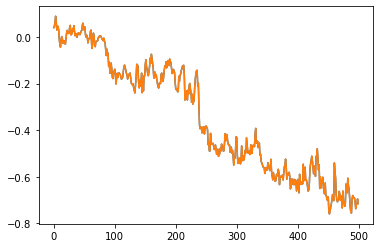

In [6]:
np.unique(np.isnan(u.ins3d[23,:,0]))
u_detrend=signal.detrend(u.ins3d[23,:,0])
u_detrend = u_detrend+u.avg3d[23,:,0]
dif = u.detrend3d[23,:,0]-u_detrend
plt.plot(u_detrend[0:500])
# plt.plot(dif[0:500])
plt.plot(u.detrend3d[23,0:500,0])